In [1]:
!pip install pinecone-client

In [7]:
import os
import yaml
import torch
import openai
import pinecone
import transformers

In [8]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = credentials['OPENAI_API_KEY']
os.environ['HUGGINGFACEHUB_API_TOKEN'] = credentials['HUGGINGFACEHUB_API_TOKEN']
os.environ['PINECONE_API_KEY'] = credentials['PINECONE_API_KEY']

openai.api_key = credentials['OPENAI_API_KEY']
pinecone.init(
            api_key=credentials['PINECONE_API_KEY'],
            environment="us-west4-gcp"  # find next to API key in console
        )

# How This Works ?
      - Using Large Knowledge DB

## Thought Process

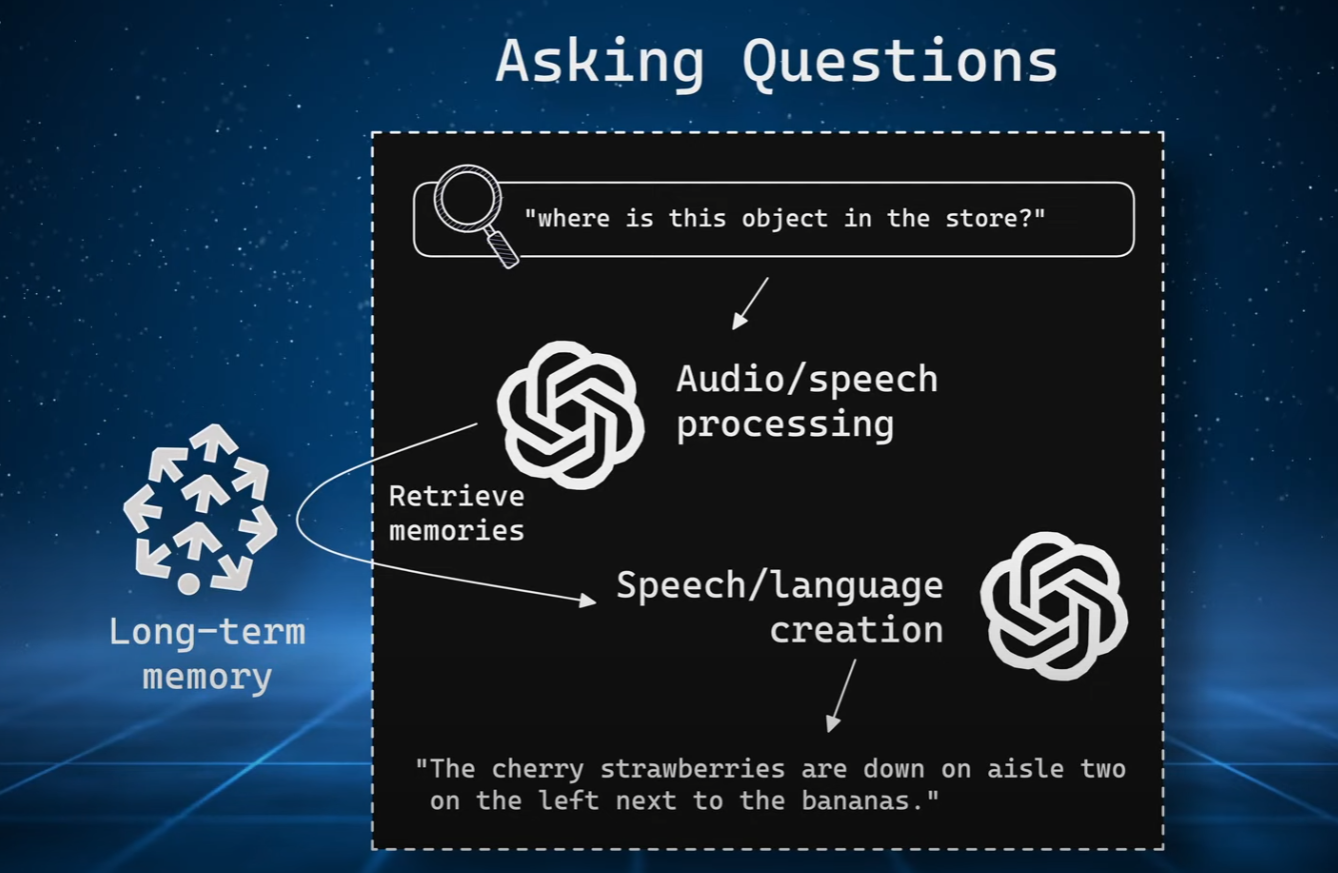

## Knowledge Base

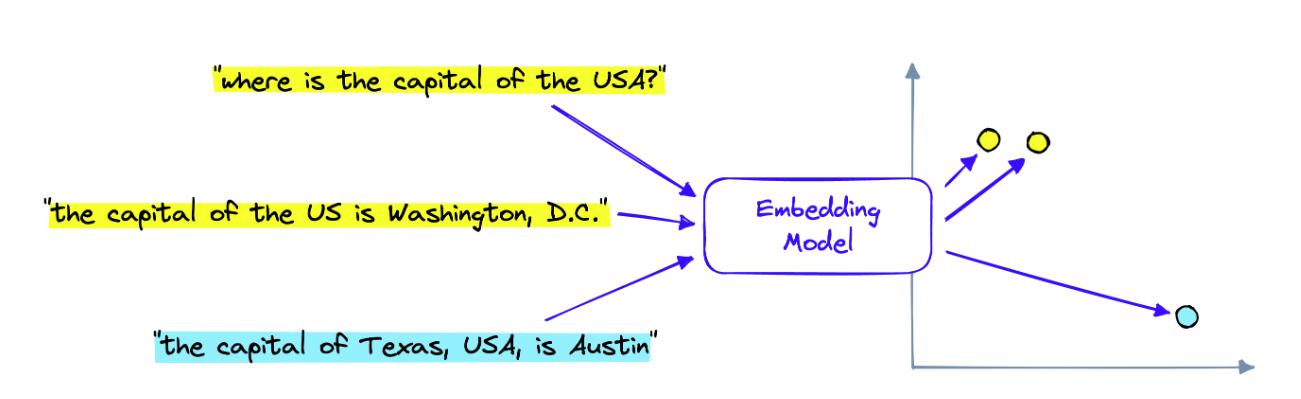

# High Level Architecture

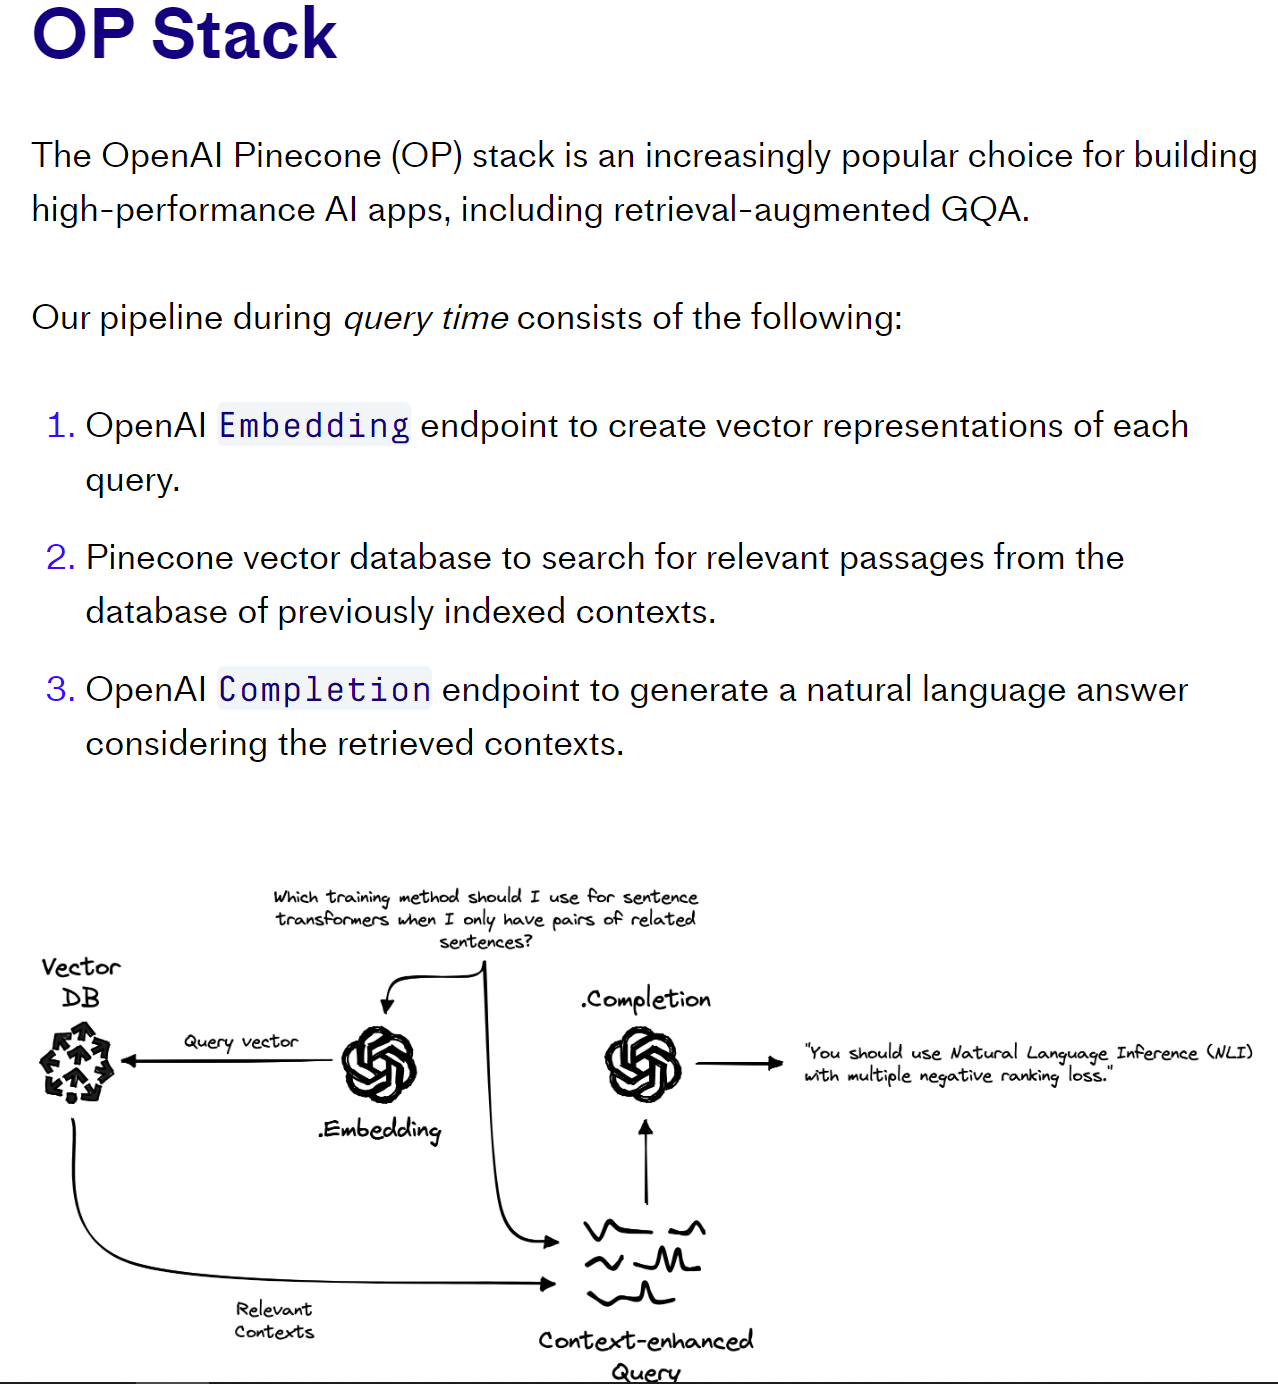

# STEP 01 : Analyze The Knowledge Base

In [15]:
import json
from sys import getsizeof
from tqdm.auto import tqdm
from datasets import load_dataset

In [16]:
data = load_dataset('jamescalam/ml-qa', split='train')
data

Found cached dataset json (C:/Users/Legion/.cache/huggingface/datasets/jamescalam___json/jamescalam--ml-qa-2cecc52fb1e2761a/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


Dataset({
    features: ['docs', 'category', 'thread', 'href', 'question', 'context', 'marked'],
    num_rows: 6165
})

#### Pinecone have few limitations. So we have to filter the data before we load it into Pinecone.
    
      * Max metadata size per vector is 40 KB.
      * Max vector dimensionality is 20,000.

In [17]:
limit = 0

for record in data:
    size = getsizeof(json.dumps(record))
    if size > 40_000:
        limit += 1

print(f"Over 40KB: {round((limit/len(data)*100),2)}%")

Over 40KB: 0.0%


In [18]:
data = data.filter(lambda x: 0 if getsizeof(
        json.dumps(x)
    ) > 40_000 else 1
)
data

Loading cached processed dataset at C:\Users\Legion\.cache\huggingface\datasets\jamescalam___json\jamescalam--ml-qa-2cecc52fb1e2761a\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-7b5c6d7e50a295a4.arrow


Dataset({
    features: ['docs', 'category', 'thread', 'href', 'question', 'context', 'marked'],
    num_rows: 6165
})

# STEP 02 : Format the Knowledge Base

    << The Format >>
        Thread title: <thread>
        Question asked: <question>
        Given answer: <context>


In [19]:
text = [
    f"Thread title: {x['thread']}\n\n"+
    f"Question asked: {x['question']}\n\n"+
    f"Given answer: {x['context']}" for x in data
]
text[0]

'Thread title: Can’t download (some) models although they are in the hub\n\nQuestion asked: Can’t download (some) models to pytorch, although they are in the hub (tried also the from_tf flag)\nError:\n404 Client Error: Not Found for url: https://huggingface.co/umarayub/t5-small-finetuned-xsum/resolve/main/config.json 1\nModels for example:\nall of those models give 404 when trying to download them\n[\n“SvPolina/t5-small-finetuned-CANARD”, “Edwardlzy/t5-small-finetuned-xsum”, “Teepika/t5-small-finetuned-xsum”,\n“HuggingLeg/t5-small-finetuned-xsum”, “V3RX2000/t5-small-finetuned-xsum”, “Teepika/t5-small-finetuned-xsum-glcoud”,\n“VenkateshE/t5-small-finetuned-xsum”, “Wusgnob/t5-small-finetuned-xsum”, “HugoZhu/t5-small-finetuned-xsum”,\n“Zazik/t5-small-finetuned-xsum”, “Paramveer/t5-small-finetuned-xsum”, “arkosark/t5-small-finetuned-xsum”,\n“RamadasK7/t5-small-finetuned-squad”, “bochaowei/t5-small-finetuned-cnn-wei2”, “Kyaw/t5-small-finetuned-xsum”,\n“ggosline/t5-small-herblables”,\n]\nThi

In [22]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")

def count_tokens(text_):
    input_ids = torch.tensor(tokenizer.encode(text_)).unsqueeze(0)
    num_tokens = input_ids.shape[1]
    return num_tokens


counts = [count_tokens(x) for x in tqdm(text)]
filtered_idxs = [i for i, x in enumerate(counts) if x < 1000]

text = [text[i] for i in filtered_idxs]
data = [data[i] for i in filtered_idxs]

100%|██████████| 6165/6165 [00:06<00:00, 952.12it/s] 


# STEP 03 : Generate Embeddings (ADA is the best for this)

In [23]:
openai.Engine.list()

<OpenAIObject list at 0x248d3daf540> JSON: {
  "data": [
    {
      "created": null,
      "id": "babbage",
      "object": "engine",
      "owner": "openai",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "davinci",
      "object": "engine",
      "owner": "openai",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "text-davinci-edit-001",
      "object": "engine",
      "owner": "openai",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "babbage-code-search-code",
      "object": "engine",
      "owner": "openai-dev",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "text-similarity-babbage-001",
      "object": "engine",
      "owner": "openai-dev",
      "permissions": null,
      "ready": true
    },
    {
      "created": null,
      "id": "code-davinci-edit-001",
      "object": "engine",
      "

In [24]:
def generate_and_store_embeddings(
                                text, 
                                ids_batch,
                                meta_batch,
                                index = None,
                                index_name = 'openai-ml-qa', 
                                embedding_model= "text-embedding-ada-002"
                                ):
    res = openai.Embedding.create(
                                input=text, 
                                engine=embedding_model
                                )
    embeds = [record['embedding'] for record in res['data']]
    # check if 'openai-ml-qa' already exists (only create index if not)
    if (index_name not in pinecone.list_indexes()) or (index is None):
        print('Creating index ...'.format(index_name))
        pinecone.create_index(
                            index_name,
                            dimension=len(res['data'][0]['embedding']),
                            metric='cosine',
                            metadata_config={'indexed': ['docs']}
                            )
        index = pinecone.Index(index_name)

    # add embeddings to index
    to_upsert = list(zip(ids_batch, embeds, meta_batch))
    index.upsert(to_upsert)
    return index


In [25]:
batch_size = 32  # process everything in batches of 32
for i in tqdm(range(0, len(text), batch_size)):
    i_end = min(i+batch_size, len(text))

    meta_batch = [data[x] for x in range(i,i_end)]
    text_batch = text[i:i_end]
    ids_batch = [str(n) for n in range(i, i_end)]

    if i == 0:
        index = generate_and_store_embeddings(
                                            text_batch,
                                            ids_batch,
                                            meta_batch
                                            )
    else:
        index = generate_and_store_embeddings(
                                            text_batch,
                                            ids_batch,
                                            meta_batch,
                                            index
                                            )

  0%|          | 0/167 [00:00<?, ?it/s]

Creating index ...


100%|██████████| 167/167 [13:33<00:00,  4.87s/it]


In [27]:
index.describe_index_stats(
                        include_metadata=True,      
                        include_index_stats=True,
                        include_index_config=True
                        )   

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 5320}},
 'total_vector_count': 5320}

# STEP 04 : Making Queries

In [9]:
def query_inference(
                    query,
                    index_name = 'openai-ml-qa', 
                    embedding_model= "text-embedding-ada-002"
                    ):
    res = openai.Embedding.create(
                                input=[query],
                                engine=embedding_model
                                )
    index = pinecone.Index(index_name)
    matches = index.query(res['data'][0]['embedding'], top_k=3, include_metadata=True)
    return matches, res

In [10]:
matches, res = query_inference("What is the difference between a neural network and a deep learning model?")
matches

{'matches': [{'id': '3813',
              'metadata': {'category': 'General Discussion',
                           'context': 'Richie_C:\n'
                                      '\n'
                                      'I had a problem with the models with '
                                      'neurons lower than 16 in a layer.\n'
                                      '\n'
                                      '\n'
                                      'The more the hidden layer the more the '
                                      'number of parameters to learn (it '
                                      'depends on what kind of layers you have '
                                      'used). Higher the number of parameters, '
                                      'higher the memory required.\n'
                                      'Please share a standalone code for '
                                      'further support. Thanks!',
                           'docs': 'tensorflow'

In [ ]:
def better_query_inference(
                            query,
                            index_name = 'openai-ml-qa', 
                            embedding_model= "text-embedding-ada-002"
                            ):
    res = openai.Embedding.create(
                                input=[query],
                                engine=embedding_model
                                )
    xq = res['data'][0]['embedding']

    # get relevant contexts
    res = index.query(xq, top_k=10, include_metadata=True)
    contexts = [
        x['metadata']['context'] for x in res['matches']
    ]

    # build our prompt with the retrieved contexts included
    prompt_start = (
        "Give an exhaustive summary and answer based on the question using the contexts below.\n\n"+
        "Context:\n"+
        "\n\n---\n\n".join(contexts)+"\n\n"+
        f"Question: {query}\n"+
        f"Answer:"
    )
    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )
    # append contexts until hitting limit
    for i in range(1, len(contexts)):
        if len("\n\n---\n\n".join(contexts[:i])) >= limit:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts[:i-1]) +
                prompt_end
            )
        elif i == len(contexts):
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts) +
                prompt_end
            )

    # now query text-davinci-003
    res = openai.Completion.create(
                                engine='text-davinci-003',
                                prompt=prompt,
                                temperature=0,
                                max_tokens=400,
                                top_p=1,
                                frequency_penalty=0,
                                presence_penalty=0,
                                stop=None
                                )
    
    res['choices'][0]['text'].strip()